In [1]:
import math
from random import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def gws(x, R):
    if x < R:
        return 1
    else:
        return 1 * np.exp((-x + R))


def inv_Gws(r, R):
    if r < R:
        result = r
    else:
        result = R - np.log(1 + (R - r))
    return result


def wsdensity(r, R, a):
    return 1. / (1 + np.exp((r - R) / a))


def WSP(R, a):
    fmax = 1
    xmin = 0
    xmax = (R + 1)

    # picks random x points
    x1 = xmax * random()
    y1 = gws(x1, R) * random()

    while y1 > wsdensity(x1, R, a):
        x1 = xmax * random()
        y1 = gws(x1, R) * random()

    r = inv_Gws(x1, R)
    phi = 2*np.pi*random()
    theta = np.pi*random()
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def boxsampler(R,a):
    fmax = 1
    xmin = 0
    xmax = 2*R

    # picks random x points
    x1 = xmax * random()
    y1 = fmax * random()

    while y1 > wsdensity(x1, R, a):
        x1 = xmax * random()
        y1 = fmax * random()

    r = x1
    phi = 2*np.pi*random()
    theta = np.pi*random()
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z, r

# The nucleon class contains nucleon coordinates, and methods for geometry.
class Nucleon:
    def __init__(self, x, y, z):
        self.bx = x
        self.by = y
        self.bz = z

    # Radial coordinate.
    def r(self):
        return np.sqrt(self.bx**2 + self.by**2+ self.bz**2)

    # Distance between this nucleon and another.
    def dist(self, other):
        dx2 = (self.bx - other.bx) ** 2
        dy2 = (self.by - other.by) ** 2
        dz2 = (self.bz - other.bz) ** 2
        return math.sqrt(dx2 + dy2 + dz2)

    # (x,y)-distance between this nucleon and another.
    def dist2(self, other):
        dx2 = (self.bx - other.bx) ** 2
        dy2 = (self.by - other.by) ** 2
        return math.sqrt(dx2 + dy2)

    # Shift the nucleon's coordinates by an impact parameter.
    def shift(self, r, phi):
        self.bx += r * math.cos(phi)
        self.by += r * math.sin(phi)


class Nucleus:
    def __init__(self, A):
        self.A = A
        # Glissando parametrization
        self.R = 1.1 * math.pow(float(self.A), 1.0 / 3.0) - 0.656 * math.pow(float(self.A), -1.0 / 3.0)
        self.aWs = 0.459
        self.hc = 0.9
        self.nucleons = []

    # This is a deliberately silly method of sampling from the WS distribution.
    # First sample from a box, and then reject. It will not fully catch the tail of
    # the distribution.
    def setup(self):
        while len(self.nucleons) < self.A:
            overlap = True
            while overlap:
                w = x = y = z = 0.
                u = 1.
                while w < u:
                    x = 2*self.R*(random() - 0.5)
                    y = 2*self.R*(random() - 0.5)
                    z = 2*self.R*(random() - 0.5)
                    r = math.sqrt(x*x + y*y + z*z)
                    w = 1./(1 + math.exp((r - self.R)/self.aWs))
                    u = random()
                n = Nucleon(x, y, z)    
                overlap = False
                for no in self.nucleons:
                    if no.dist(n) < self.hc:
                        overlap = True
                        break
            self.nucleons.append(n)

def impactsampler(bMax):
    b = np.sqrt(bMax**2*random())
    phi = 2*np.pi*random()
    return b, phi

def collision_bDisk(nuclei, impact, rDisk):
    Ncoll = []
    Ncoll_all = []
    for nu, bb in zip(nuclei, impact):
        nc = 0
        # Make a proton.
        proton = Nucleon(0,0,0)
        # Shift the impact parameter of the proton
        proton.shift(bb[0],bb[1])
        # Loop over all nucleons in nucleus, and check for overlap.
        for n in nu.nucleons:
            if n.dist2(proton) <= rDisk:
                nc += 1
        Ncoll_all.append(nc)
        if nc > 0:
            Ncoll.append(nc)

    return Ncoll, Ncoll_all


def collision_gDisk(nuclei, impact, rDisk, alpha):
    Ncoll = []
    Ncoll_all = []
    for nu, bb in zip(nuclei, impact):
        nc = 0
        # Make a proton.
        proton = Nucleon(0,0,0)
        # Shift the impact parameter of the proton
        proton.shift(bb[0],bb[1])
        # Loop over all nucleons in nucleus, and check for overlap.
        for n in nu.nucleons:
            x1 = random()
            if alpha>=x1:
                if n.dist2(proton) <= rDisk:
                    nc += 1
        Ncoll_all.append(nc)
        if nc > 0:
            Ncoll.append(nc)

    return Ncoll, Ncoll_all

def gscatter(axes, xArray, yArray, radius=1.25, **kwargs):
    # Filter arguments for labels.
    newarg = {}
    for key,value in kwargs.items():
        if key != "label":
            newarg[key] = value
    # Set a sensible axis range.
    try:
        axes.axis([min(-10,min(xArray)), max(10,max(xArray)), min(-10,min(yArray)), max(10,max(yArray))])
    except:
        axes.axis([-10,10,-10,10])
    # Go through the nucleons.
    for x, y in zip(xArray, yArray):
        # Add the first with a label.
        if x == xArray[0]:
            circle = Circle((x,y), radius=radius, **kwargs)
            axes.add_patch(circle)
        else:
            # Add the rest without.
            circle = Circle((x,y), radius=radius, **newarg)
            axes.add_patch(circle)
    # Make the figure presentation worthy.
    axes.set_xlabel("x [fm]")
    axes.set_ylabel("y [fm]")
    axes.set_aspect("equal")
    leg = axes.legend(scatterpoints=1)
    for l in leg.legendHandles:
        l._sizes = [30]
    return True

    
def T_bDisk(b,R):
    if b<R:
        return 1
    else:
        return 0

def sigmatot_bDisk(b_arr, R):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_bDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_bDisk[i] = T_bDisk(b_arr[i], R)
        I+=2*Ts_bDisk[i]
    I=V*1/(len(b_arr))*I
    return I, Ts_bDisk

def T_gDisk(b, R, alpha):
    u = random()
    if (b<=R) and u<=alpha:
        return 1
    else:
        return 0

def sigmatot_gDisk(b_arr, R, alpha):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_gDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_gDisk[i] = T_gDisk(b_arr[i], R, alpha)
        I+=2*Ts_gDisk[i]
    I=V*1/len(b_arr)*I
    return I, Ts_gDisk


In [2]:
nuclei = []
bMax = 7
num_impact = 10000
num_nuc = 10000
A=63
rDisk = np.sqrt(4.39/np.pi)
alpha = 0.5
g_rDisk = np.sqrt(rDisk**2/alpha)


for i in range(num_nuc):
    Au = Nucleus(A)
    if (i)%(num_nuc/10)==0:
                print(f'setup {i/num_nuc*100}% complete')
    Au.setup()
    nuclei.append(Au)


impact = []
for i in range(num_impact):
    impact.append(impactsampler(bMax))

b_arr = [bb[0] for bb in impact]
phi_arr = [pp[1] for pp in impact]


Ncoll, Ncoll_all = collision_bDisk(nuclei, impact, rDisk)
Ncoll_g, Ncoll_all_g = collision_gDisk(nuclei, impact, g_rDisk, alpha)



setup 0.0% complete
setup 10.0% complete
setup 20.0% complete
setup 30.0% complete
setup 40.0% complete
setup 50.0% complete
setup 60.0% complete
setup 70.0% complete
setup 80.0% complete
setup 90.0% complete


In [3]:

# getting the mean value total cross section for the black disk and gray disk for 200 GeV
num_barrs = 10000
bMax_p = 2
def cross_section_calc(num_barrs, bMax_p, rDisk, g_rDisk, alpha, num_impact):
    sigmatot_barr = np.zeros(num_barrs)
    sigmatot_garr = np.zeros(num_barrs)
    Ts_bDisk_list = []
    Ts_gDisk_list = []

    for i in range(num_barrs):
        impacts = []
        if (i % (num_barrs/10)) == 0:
            print(f'calculating cross section {i/num_barrs*100}% done')
        for j in range(num_impact):
            impacts.append(impactsampler(bMax_p))

        b_arrs = [bb[0] for bb in impacts]

        sigmatot_b, Ts_bDisk = sigmatot_bDisk(b_arrs, rDisk)
        sigmatot_g, Ts_gDisk = sigmatot_gDisk(b_arrs, g_rDisk, alpha)
        
        sigmatot_barr[i] = sigmatot_b
        sigmatot_garr[i] = sigmatot_g

        Ts_bDisk_list.append(Ts_bDisk)
        Ts_gDisk_list.append(Ts_gDisk)

    s_b_mean = np.mean(sigmatot_barr)
    s_g_mean = np.mean(sigmatot_garr)

    s_b_std = np.std(sigmatot_barr)
    s_g_std = np.std(sigmatot_garr)
    return s_b_mean, s_b_std, s_g_mean, s_g_std, Ts_bDisk_list, Ts_gDisk_list

s_b_mean, s_b_std, s_g_mean, s_g_std, Ts_bDisk_list, Ts_gDisk_list = cross_section_calc(num_barrs, bMax_p, rDisk, g_rDisk, alpha, num_impact)
print(r'$\sigma_{tot}^pp$ black disk sim =',s_b_mean, r'$\pm$',s_b_std ,'[mb]') 
print(r'$\sigma_{tot}^pp$ black disk analytical =',10*2*np.pi*rDisk**2,'[mb]')

print(r'$\sigma_{tot}^pp$ gray disk sim =',s_g_mean, r'$\pm$', s_g_std ,'[mb]') 
print(r'$\sigma_{tot}^pp$ gray disk analytical =',10*2*np.pi*alpha*g_rDisk**2,'[mb]')

calculating cross section 0.0% done
calculating cross section 10.0% done
calculating cross section 20.0% done
calculating cross section 30.0% done
calculating cross section 40.0% done
calculating cross section 50.0% done
calculating cross section 60.0% done
calculating cross section 70.0% done
calculating cross section 80.0% done
calculating cross section 90.0% done
$\sigma_{tot}^pp$ black disk sim = 87.7923810199851 $\pm$ 1.1999141178125137 [mb]
$\sigma_{tot}^pp$ black disk analytical = 87.8 [mb]
$\sigma_{tot}^pp$ gray disk sim = 87.78719787912674 $\pm$ 1.189005331933726 [mb]
$\sigma_{tot}^pp$ gray disk analytical = 87.8 [mb]


float64 float64 float64 float64
[0.45245532 1.97710759 1.50067633]
[0.67268863 1.53327532 0.59713305 0.6119814 ]


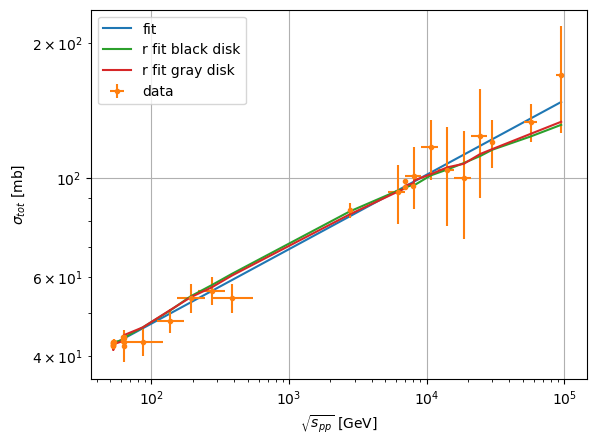

In [4]:
import pandas as pd
from scipy.optimize import curve_fit



df = pd.read_csv('cross_section_data.csv', sep='\s+', header=None)

m_p = 0.9383 # GeV/c^2
p_lab = df[1]

def plab_to_sqrts(k):
    sqrt_s = np.sqrt(2*(m_p**2+m_p*np.sqrt(m_p**2+df[k]**2)))
    return sqrt_s

sqrt_s = np.sqrt(2*(m_p**2+m_p*np.sqrt(m_p**2+p_lab**2)))
df[14] = sqrt_s

E_min = 50 # GeV
# disregarding all resluts with a std of 0 and energy less than E_min
df = df[(df[5]!=0) & (df[6]!=0) & (df[14]>E_min)].reset_index()

sqrt_s = df[14]
sqrt_s_stam = sqrt_s - plab_to_sqrts(2)
sqrt_s_stap =  plab_to_sqrts(3) - sqrt_s
sig = df[4]
sta_errp = df[5]
sta_errm = df[6]


print(sqrt_s.dtype, sqrt_s_stam.dtype, sig.dtype, sta_errp.dtype )

# making a fit out of the data
def cross_fit(sqrt_s,a,b):
    return np.exp(a*np.log(sqrt_s)+b)


popt_E, pcov_E = curve_fit(cross_fit, xdata=sqrt_s, ydata=sig, sigma=sta_errm, absolute_sigma=True)
a, b = popt_E # will come in handy when doing fits for rDisk
perr_E = np.sqrt(np.diag(pcov_E))
sorted_sqrt_s = np.sort(sqrt_s)

plt.plot(sorted_sqrt_s, cross_fit(sorted_sqrt_s,*popt_E), label='fit')

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{tot}$ [mb]')
plt.xlabel(r'$\sqrt{s_{pp}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()



def rDisk_b(sqrt_s,b,c,d):
    rDisk = a/c*np.log(d*sqrt_s)+b
    return rDisk

# def sig_b(sqrt_s,b,c):
#     bMax_p=2
#     num_barrs=100
#     num_impact=100
#     sigmatot_barr = np.zeros(num_barrs)
#     s_b_mean_arr = np.zeros(len(sqrt_s))
#     s_b_std_arr = np.zeros(len(sqrt_s))
#     rDisk = rDisk_b(sqrt_s,b,c)
#     for k in range(len(sqrt_s)):
#         for i in range(num_barrs):
#             impacts = []
#             for j in range(num_impact):
#                 impacts.append(impactsampler(bMax_p))

#             b_arrs = [bb[0] for bb in impacts]

#             sigmatot_b, _ = sigmatot_bDisk(b_arrs, rDisk[k])

#             sigmatot_barr[i] = sigmatot_b
        
#         s_b_std = np.std(sigmatot_barr)
#         s_b_std_arr[k] = s_b_std
#         s_b_mean = np.mean(sigmatot_barr)
#         s_b_mean_arr[k] = s_b_mean
#     return s_b_mean_arr, s_b_std_arr

def sig_fit_b(sqrt_s,b,c,d):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    rDisk = rDisk_b(sqrt_s,b,c,d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmatot_bDisk(b_arrs, rDisk[k])

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
    return s_b_mean_arr

def rDisk_g(sqrt_s, b, c, d):
    rDisk = np.log(d*sqrt_s)*(a/c)+b
    return rDisk

# def sig_g(sqrt_s, b, c, alpha):
#     bMax_p=2
#     num_barrs=100
#     num_impact=100
#     sigmatot_barr = np.zeros(num_barrs)
#     s_g_mean_arr = np.zeros(len(sqrt_s))
#     s_g_std_arr = np.zeros(len(sqrt_s))
#     rDisk = rDisk_g(sqrt_s,b,c)
#     for k in range(len(sqrt_s)):
#         for i in range(num_barrs):
#             impacts = []
#             for j in range(num_impact):
#                 impacts.append(impactsampler(bMax_p))

#             b_arrs = [bb[0] for bb in impacts]
#             sigmatot_g, _ = sigmatot_gDisk(b_arrs, rDisk[k], alpha)

#             sigmatot_barr[i] = sigmatot_g
#         s_g_std = np.std(sigmatot_barr)
#         s_g_std_arr[k] = s_g_std
#         s_g_mean = np.mean(sigmatot_barr)
#         s_g_mean_arr[k] = s_g_mean
#     return s_g_mean_arr, s_g_std_arr

def sig_fit_g(sqrt_s, b, c, d, alpha):
    bMax_p=3
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_g_mean_arr = np.zeros(len(sqrt_s))
    rDisk = rDisk_g(sqrt_s, b, c, d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]
            sigmatot_g, _ = sigmatot_gDisk(b_arrs, rDisk[k], alpha)

            sigmatot_barr[i] = sigmatot_g

        s_g_mean = np.mean(sigmatot_barr)
        s_g_mean_arr[k] = s_g_mean
    return s_g_mean_arr

# want to make a fit and compare it to the original fit
popt_b, pcov_b = curve_fit(sig_fit_b, xdata=sqrt_s, ydata=sig, sigma=sta_errm, p0=[1/2,2,1], method='lm', epsfcn=0.1)
print(popt_b)
popt_g, pcov_g = curve_fit(sig_fit_g, xdata=sqrt_s, ydata=sig, sigma=sta_errm, p0=[1/2, 2, 1, 1/2], method='lm', epsfcn=0.1)
print(popt_g)
# sig_bs, sig_b_err = sig_b(sorted_sqrt_s, *popt_b)
# sig_gs, sig_g_err = sig_g(sorted_sqrt_s, *popt_g)
# plt.errorbar(sorted_sqrt_s, sig_bs, yerr=sig_b_err, marker='.', label='r fit black disk')
# plt.errorbar(sorted_sqrt_s, sig_gs, yerr=sig_g_err, marker='.', label='r fit gray disk')
plt.plot(sorted_sqrt_s, sig_fit_b(sorted_sqrt_s, *popt_b), label='r fit black disk')
plt.plot(sorted_sqrt_s, sig_fit_g(sorted_sqrt_s, *popt_g), label='r fit gray disk')
plt.legend()
plt.show()


0.3358426897239706
[ 0.82173599  0.36542558 -1.91242661 -0.91546779 -0.23494028  0.88296087
 -2.47491821  1.15649072  0.56869857  1.1690346   1.33753487  0.6863967
  0.8084316   1.18905809 -0.46052741  0.261657    1.93609152 -0.3277652
  0.29631895  2.09319346 -0.17323841  1.01766353  1.04897817  2.03085373
  1.74997759  1.72989546  0.88092106 -2.78007119  0.50275371  0.11192322
  6.78246922  3.27286314]


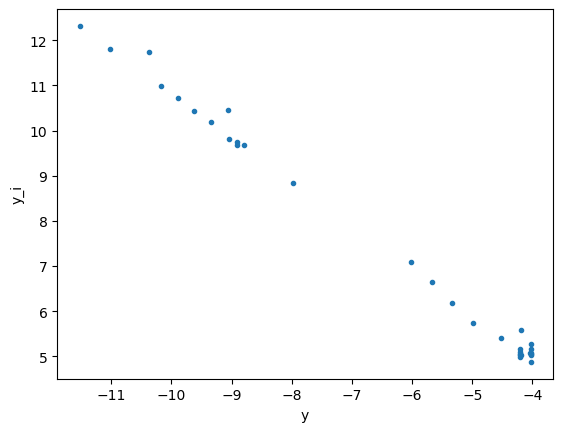

In [28]:
# making some dipoles
from random import choice
from random import random
alpha_s = 0.12 # alpha_s(M_z**2)
Nc = 3

dip_r = 1/sorted_sqrt_s

# confused by what should be p_plus and p_t in this code comparing to appendix
p_plus = sorted_sqrt_s
p_t = m_p
y = np.log(p_t/p_plus)
p_minus = p_t*np.exp(y)

rho = np.exp(-y)/p_plus # taking the minimum dipole distance here, don't know if it's correct B&O paper

A = (1+(p_t)**2)/4

def y_sampler(y):
    ys = np.zeros(len(y))
    for j in range(len(y)):
        R = random()
        y_j = 1/2*np.sqrt((np.log(A)+2*y[j])**2-np.pi*np.log(R)/(Nc*alpha_s))-1/2*np.log(A)
        ys[j] = y_j
    return ys

def r_theta_sampler(rho):
    phi = np.zeros(len(rho))
    r = np.zeros(len(rho))
    for i in range(len(rho)):
        reject = True
        while reject:
            phi[i] = 2*np.pi*random()
            R3 = random()
            r[i] = np.sqrt(1/4*rho[i]**(2*R3)/((rho[i]**2+1/4)**R3-rho[i]**(2*R3)))
            if r[i]*np.cos(phi[i])>1/2:
                break
    return r, phi
rs, phis = r_theta_sampler(rho)

def rx_ry_sampler(rs, phis):
    rx = rs*np.cos(phis)
    ry = rs*np.sin(phis)
    for i in range(int(len(rs)/2)):
        index1 = choice(range(len(rs)))
        index2 = choice(range(len(rs)))
        rx[index1] = 1-rx[index1]
        ry[index2] = 1-ry[index2]

    return rx, ry
rx, ry = rx_ry_sampler(rs, phis)
print(rx)
plt.plot(y, y_sampler(y),'.', label='sampled y')
plt.xlabel('y')
plt.ylabel('y_i')
plt.show()


# f_ij = 

# def T(b):
#     return 1-np.exp(np.sum(f_ij))

# def sigmatot(b_arr):
#     V = 10*max(b_arr)**2*np.pi
#     I = 0
#     Ts = np.zeros_like(b_arr)
#     for i in range(len(b_arr)):
#         Ts[i] = T(b_arr[i])
#         I+=2*Ts[i]
#     I=V*1/len(b_arr)*I
#     return I, Ts


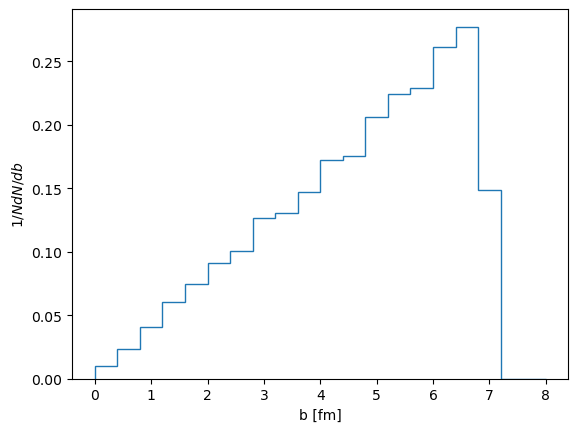

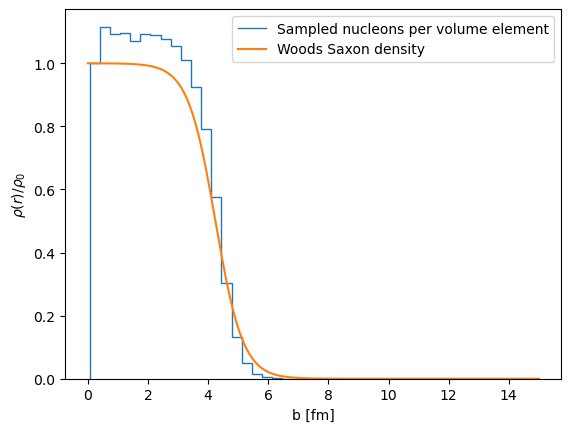

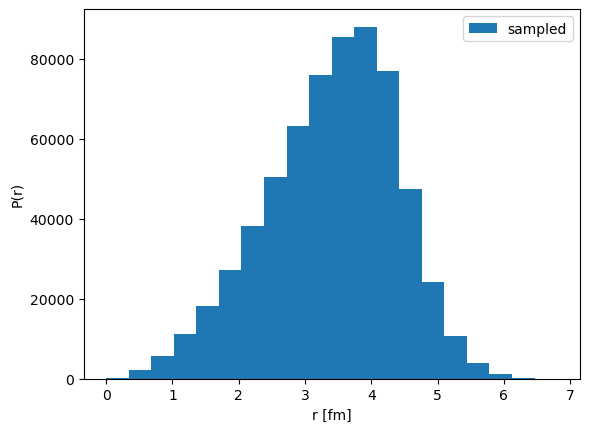

C:\Users\smula\AppData\Local\Temp\ipykernel_12468\158576504.py:203: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


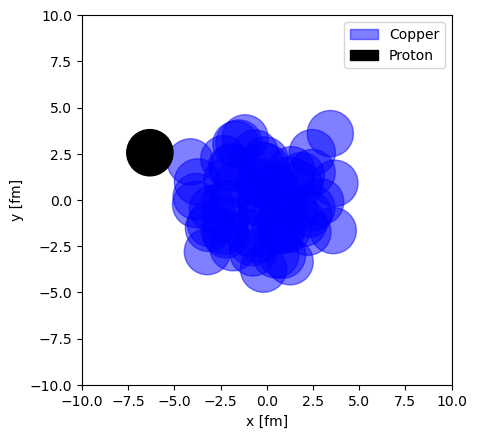

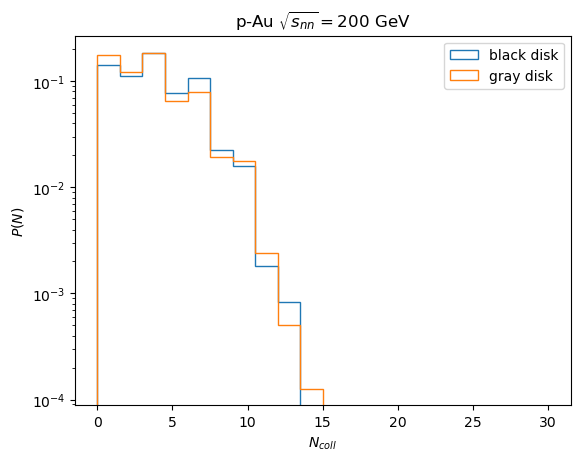

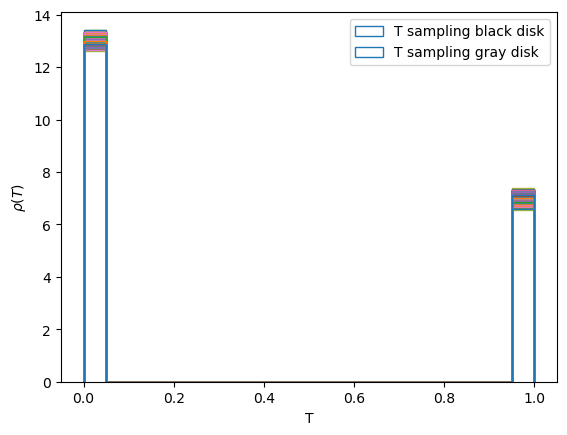

In [ ]:
#plotting

#b sampling
plt.hist(b_arr, range=[0,bMax+1], histtype='step', bins=20, density=True, label='sampled b')
plt.xlabel('b [fm]')
plt.ylabel(r'$1/N dN/db$')
plt.show()

rv = [n.r() for nu in nuclei for n in nu.nucleons]

counts, bins = np.histogram(rv,bins=20,density=True)
dV = [(bins[i+1]**3-bins[i]**3)/bins[len(bins)-1]**3 for i in range(0,len(bins)-1)]
wcounts = [c/dVV for dVV, c in zip(dV,counts)]

# Normalizing such that rho(0) = 1 as per convention.
norm = wcounts[0]
wcounts = [c/norm for c in wcounts]

# Plotting
plt.stairs(wcounts,bins,label="Sampled nucleons per volume element")

# Compare to the density.
def wsFunction(x,A):
    R = 1.12*A**(1/3)-0.86*A**(-1/3)
    a = 0.459
    return 1/(1+np.exp((x-R)/a))

x = np.linspace(0,15, 10000)
plt.plot(x,wsFunction(x,A),label="Woods Saxon density")
plt.ylabel(r"$\rho(r)/\rho_0$")
plt.xlabel("b [fm]")
plt.legend()
plt.show()


plt.hist(rv, range=[0,max(rv)], bins=20, label = 'sampled' )
plt.xlabel('r [fm]')
plt.ylabel('P(r)')
plt.legend()
plt.show()

fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
Au.setup()
xc = [n.bx for n in Au.nucleons]
yc = [n.by for n in Au.nucleons]

# Add a test proton at some impact parameter to see if everything works as it should.
testProton = Nucleon(0,0,0)

# You could play around with different impact parameters. I also like to visualize things.
testProton.shift(impact[0][0],impact[0][1])

gscatter(ax3, xc, yc, color='blue', label='Copper', alpha=0.5)
gscatter(ax3, [testProton.bx], [testProton.by], color='black', label='Proton')
plt.show()


#plotting the probability for ncoll
plt.hist(Ncoll, range = [0,30], bins = 20, density = True, histtype = 'step', label=r"black disk")
plt.hist(Ncoll_g, range = [0,30], bins = 20, density = True, histtype = 'step', label=r"gray disk")
plt.xlabel(r'$N_{coll}$')
plt.ylabel(r'$P(N)$')
plt.yscale('log')
plt.title(r'p-Au $\sqrt{s_{nn}}=200$ GeV')
plt.legend()
plt.show()


plt.hist(Ts_bDisk_list, bins=20, histtype='step', density=True, label='T sampling black disk')
plt.hist(Ts_gDisk_list, bins=20, histtype='step', density=True, label='T sampling gray disk')
plt.xlabel('T')
plt.ylabel(r'$\rho(T)$')
plt.legend()
plt.show()

Text(0, 0.5, '$\\langle N_{coll} \\rangle$')

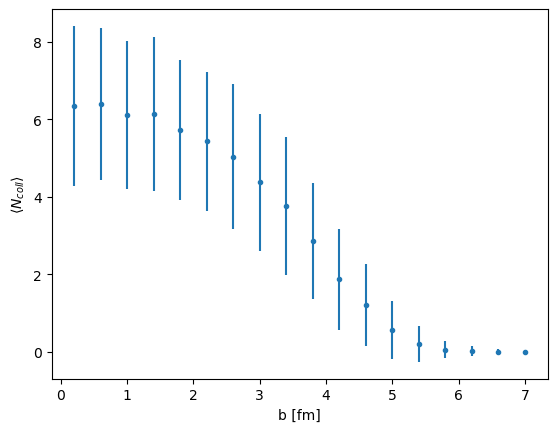

In [ ]:
import scipy.stats

means_result = scipy.stats.binned_statistic([i[0] for i in impact], [Ncoll_all, [n**2 for n in Ncoll_all]], 
                                            bins=20, range=(0,8), statistic='mean')
means, means2 = means_result.statistic
standard_deviations = np.sqrt(means2 - means**2)
bin_edges = means_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, linestyle='none', marker='.')
plt.xlabel('b [fm]')
plt.ylabel(r'$\langle N_{coll} \rangle$')